In [1]:
%load_ext autoreload
%autoreload 2

# `rpreactor` quick-start guide

This quick-start guide is intended for users who want to dive head-first in `rpreactor` features.
We assume `rpreactor` is correctly installed and that you have some understanding of [reaction rules](https://retrorules.org/doc).

We will see how to use `rpreactor` to:

* build a reaction rule database,
* recover in this database all reactions that use a specific chemical as substrate (or product),
* predict new reactions under an enzymatic substrate promiscuity hypothesis,
* search for similar reactions.


In [2]:
import rpreactor

rpreactor.__version__

'0.0.12+61.g12dad48.dirty'

## Build a reaction rule database

A pregenerated set of reaction rules can be download from [RetroRules](https://retrorules.org). It contains information of all known enzymatic reactions from MetaNetX v3.0. `rpreactor` can load those reaction rules.

Download and extract the files:

In [ ]:
!wget https://retrorules.org/dl/preparsed/rr02/rp3/hs

In [ ]:
!tar -xzf hs

Build a small database (this will take some time) from the reaction rules:

In [3]:
path_tsv = "retrorules_rr02_rp3_hs/retrorules_rr02_flat_all.tsv"
path_sqlite = "rr02_hs.sqlite3"

In [ ]:
%%time

rpreactor.create_db_from_retrorules(path_retrosmarts_tsv=path_tsv, db_path=path_sqlite, with_hs=True)

In [4]:
%%time

o = rpreactor.RuleBurner(db_path=path_sqlite, with_hs=True)
print(o)

Connected to a database with 229862 rules, 12490 compounds, and 666144 results (at 'rr02_hs.sqlite3'). Last compute call yield 0 results (0 precomputed, 0 new); 0 errors were caught (details in the logs), and 0 timeouts were hit.
CPU times: user 549 ms, sys: 173 ms, total: 722 ms
Wall time: 3.19 s


You now have a database with pregenerated reaction rules that you may query, either directly or through `rpreactor`.

You may also find it useful to get a direct access to RetroRules data:

In [5]:
import pandas as pd

df_rr = pd.read_csv(path_tsv, sep='\t')
df_rr.head(3)

,# Rule_ID,Legacy_ID,Reaction_ID,Diameter,Rule_order,Rule_SMARTS,Substrate_ID,Substrate_SMILES,Product_IDs,Product_SMILES,Rule_SMILES,Rule_SMARTS_lite,Score,Score_normalized,Reaction_EC_number,Reaction_direction,Rule_relative_direction,Rule_usage
0,RR-02-fbdda75e23f518b6-02-F,MNXR94682_MNXM821,MNXR94682,2,1,([#6&v4:1](=[#8&v2:2])(-[#6&v4:3](-[#6&v4:4])(...,MNXM821,[H][C](=[O])[C]([H])([H])[C]([H])([H])[H],MNXM90191,[H][O][C]([H])([H])[C]([H])([O][H])[C]([H])([H...,[C](=[O])(-[C](-[C])(-[H])-[H])-[H]>>[C](-[O]-...,([#6&v4](=[#8&v2])(-[#6&v4](-[#6&v4])(-[#1&v1]...,4.295611,0.104697,NaN,0,1,both
1,RR-02-0250d458c4991a7d-02-F,MNXR94682_MNXM90191,MNXR94682,2,1,([#6&v4:1](-[#8&v2:2]-[#1&v1:3])(-[#6&v4:4](-[...,MNXM90191,[H][O][C]([H])([H])[C]([H])([O][H])[C]([H])([H...,MNXM2.MNXM821,[H][O][H].[H][C](=[O])[C]([H])([H])[C]([H])([H...,[C](-[O]-[H])(-[C](-[C])(-[O]-[H])-[H])(-[H])-...,([#6&v4](-[#8&v2]-[#1&v1])(-[#6&v4](-[#6&v4])(...,4.295611,0.104697,NaN,0,-1,both
2,RR-02-c3681aa8011dc014-02-F,MNXR94689_MNXM101404,MNXR94689,2,1,([#6&v4:1]-[#6&v4:2](=[#8&v2:3])-[#6&v4:4])>>(...,MNXM101404,[H][O][C](=[O])[C]([H])([H])[C]([H])([H])[C]([...,MNXM9689,[H][O][C](=[O])[C]([H])([H])[C]([H])([H])[C]([...,[C]-[C](=[O])-[C]>>[C]-[C](-[O]-[H])(-[C])-[H],([#6&v4]-[#6&v4](=[#8&v2])-[#6&v4])>>([#6&v4]-...,3.068557,0.140673,1.1.1.-,0,1,both


## Direct database access

`rpreactor` uses [sqlite3](https://docs.python.org/3/library/sqlite3.html#module-sqlite3) internally. With some knowledge of the schema, you may use the connection to build specific datasets or to retrieve some objects.

For instance, `rpreactor` pregenerated reaction rules use chemicals in the MetaNetX namespace. Consequently, it is fairly easy to retrieve molecules using their MetaNetX identifier:

In [6]:
target = 'MNXM680'  # MetaNetX identifier for caffeine

target in o.chemicals

True

Using `rdkit` package, you may depict the molecule:

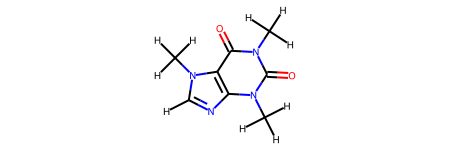

In [7]:
import rdkit 

tmp = o.db.execute("select rd_mol from molecules where id=?;", [target]).fetchone()
rdkit.Chem.Mol(tmp[0])

To showcase a more complex query, you may be interested in all the reactions that explicitely reference caffeine ("MNXM680" in MetaNetX namespace) as a product (in bidirectional or forward reactions):

In [8]:
%%time

query = """
select sid, pid, rid
from results
join rules as r on r.id=results.rid
where pid=? and r.diameter=16 and r.direction in (0, 1)
"""

ans = []
for sid, pid, rid in o.db.execute(query, [target]).fetchall():
    ans.append({
        "from": sid,
        "to": pid,
        "with": rid,
    })

df = pd.DataFrame.from_dict(ans)
df

CPU times: user 1.64 s, sys: 1.1 s, total: 2.74 s
Wall time: 15.8 s


,from,to,with
0,MNXM2761,MNXM680,RR-02-d24158da3cc6f641-16-F
1,MNXM905,MNXM680,RR-02-c9bb498ec42daefa-16-F
2,MNXM758,MNXM680,RR-02-98f3334663f7b38f-16-F


Much like chemicals, you can vizualize reaction rules with RDKit:

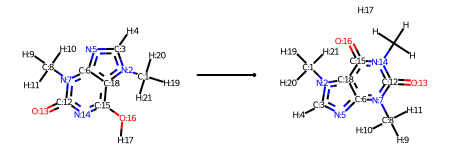

In [9]:
one_rid = df['with'].values[1]
tmp = o.db.execute("select rd_rule from rules where id=?;", [one_rid]).fetchone()
rd_rule = rdkit.Chem.rdChemReactions.ChemicalReaction(tmp[0])
rd_rule

This can comes in handy to check what the rule is doing. Remember that a reaction rule is not a direct representation of the reaction that was used to build it! [More information about reaction rules](https://retrorules.org/doc).

Using the rule identifier and crossreferences from the rules, you may retrieve associated MetaNetX identifiers, from which you will be able to retrieve the associated genes using MetaNetX cross-references:

In [10]:
ans = df_rr.loc[df_rr['# Rule_ID'].isin(df['with']),
                ['# Rule_ID', 'Reaction_ID', 'Reaction_EC_number', 'Rule_usage']]
ans

,# Rule_ID,Reaction_ID,Reaction_EC_number,Rule_usage
321107,RR-02-c9bb498ec42daefa-16-F,MNXR111503,2.1.1.160,forward
321109,RR-02-98f3334663f7b38f-16-F,MNXR111504,2.1.1.160,forward
346078,RR-02-d24158da3cc6f641-16-F,MNXR135657,NaN,both


Of course, since we solely exploited MetaNetX data, you could have acheived the same result directly querying MetaNetX interface or [SPARQL endpoint](https://rdf.metanetx.org/).

`rpreactor` should be used when you want to abstract known reaction around their reaction center. Doing so, you apply an enzymatic promiscuity hypothesis.

## Predict reactions under a enzyme promiscuity hypothesis

The true power of `rpreactor` is to predict new reactions, i.e. new associations between substrate, product and enzyme. 

Enzymes may be able to perform the chemical reaction(s) they are known for on a variety of substrates that are structurally *close-enough* to their native substrate. This is the so-called **enzyme substrate promiscuity**. Hence, if we can predict alternative promiscuious substrates of a known chemical reaction, then we can predict new reactions.

`rpreactor` **reaction rules model enzyme substrate promiscuity** by ignoring atoms that are far away from the reaction center of reaction(s) (atoms and bonds that change between the substrate and the product). Of course, we do not know the true extent of an enzyme's promiscuity before actually testing it *in vivo* or *in vitro*. Reaction rules are merely a mean to make an hypothesis on an enzyme's promiscuity: it is a fuzzy search of things that might work and that could be worth to try if it is expected to bring enough value.
The extent of the promiscuity hypothesis is parametrized with the "diameter": it represent the number of bonds of the substructure kept to create the reaction rule, counting away from the reaction center. Consequently, a rule with a low diameter makes a bigger/riskier hypothesis than a rule with a high diameter. 

`rpreactor` applies reaction rules to candidate substrates. If the reaction is predicted to occur, the product will be yield.

Here, we apply all our rules in reverse direction at diameter 8 on caffeine:

In [11]:
%%time

# Gather the rules
query = """
select id
from rules
where diameter=8 and direction in (-1, 0)
"""

rule_list = [x[0] for x in o.db.execute(query).fetchall()]
print(f"Found {len(rule_list)} rules.")

# Apply all rules on target
tasks = [(rule, target) for rule in rule_list]
results = [x for x in o.compute(rule_mol=tasks)]

# Store the results into a dataframe and retrieve the associated MNXR
ems = pd.DataFrame.from_dict(results)
ans_d8 = df_rr.loc[df_rr['# Rule_ID'].isin(ems['rule_id']),
                ['# Rule_ID', 'Reaction_ID', 'Reaction_EC_number', 'Rule_usage']]
ans_d8

Found 19700 rules.
CPU times: user 22.5 s, sys: 10.5 s, total: 32.9 s
Wall time: 1min


,# Rule_ID,Reaction_ID,Reaction_EC_number,Rule_usage
145256,RR-02-ec44834d3f79b1ea-08-F,MNXR111503,2.1.1.160,retro
145258,RR-02-24a75e69ed790fcb-08-F,MNXR111504,2.1.1.160,retro
170225,RR-02-d1354df4e581f81c-08-F,MNXR135657,NaN,both


Diameter 8 did not yield new results: all those reactions are known to produce caffeine and were already retrieved with a direct database access (like we saw before).

Now, we apply all our rules in reverse direction on caffeine again, but at diameter 4 which will allow more promiscuity:

In [12]:
%%time

# Gather the rules
query = """
select id
from rules
where diameter=4 and direction in (-1, 0)
"""

rule_list = [x[0] for x in o.db.execute(query).fetchall()]
print(f"Found {len(rule_list)} rules.")

# Apply all rules on target
tasks = [(rule, target) for rule in rule_list]
results = [x for x in o.compute(rule_mol=tasks)]

# Store the results into a dataframe and retrieve the associated MNXR
ems = pd.DataFrame.from_dict(results)
ans_d4 = df_rr.loc[df_rr['# Rule_ID'].isin(ems['rule_id']),
                ['# Rule_ID', 'Reaction_ID', 'Reaction_EC_number', 'Rule_usage']]
ans_d4

Found 16376 rules.
CPU times: user 16.8 s, sys: 8.46 s, total: 25.2 s
Wall time: 47.9 s


,# Rule_ID,Reaction_ID,Reaction_EC_number,Rule_usage
44209,RR-02-53f3f59247aeaff8-04-F,MNXR95106,1.1.1.205,both
46939,RR-02-53f3f59247aeaff8-04-F,MNXR100747,1.17.1.4,forward
47013,RR-02-3c9b7ee5f2298f12-04-F,MNXR100830,1.1.1.205,both
57328,RR-02-687da592563df925-04-F,MNXR111502,"2.1.1.159,2.1.1.160",retro
57330,RR-02-070202f1035742cd-04-F,MNXR111503,2.1.1.160,retro
57332,RR-02-d1c3a9566e7d1bad-04-F,MNXR111504,2.1.1.160,retro
58026,RR-02-97017baa2e6d8497-04-F,MNXR111955,NaN,both
70814,RR-02-eff8fb71a6dc722a-04-F,MNXR121968,NaN,retro
70816,RR-02-1907a1bc89b086bf-04-F,MNXR121969,NaN,retro
79557,RR-02-aa28b9e16b92b6fd-04-F,MNXR130283,1.1.1.205,both


You can see that by lowering the diameter we got more reactions predicted to produce caffeine. Extracting the new ones:

In [13]:
set(ans_d4['Reaction_ID'].values) - set(ans_d8['Reaction_ID'].values)

{'MNXR100747',
 'MNXR100830',
 'MNXR111502',
 'MNXR111955',
 'MNXR121968',
 'MNXR121969',
 'MNXR130283',
 'MNXR135651',
 'MNXR135655',
 'MNXR95106'}

Of course, such predicted activities must be validated in vivo and a careful manual inspection should be executed to filter out reactions without associated genes, having a bad thermodynamic, etc.

If for one reason or another the reactions and enzymes known to produce caffeine didn't fit our purpose, we would have found new candidates using our promiscuity hypothesis. Lowering the diameter provides more candidates, but presumably riskier ones.

## Find similar reactions

There are many ways to define similarity for chemical reactions. For instance, you may consider that two reactions are similar if their respective substrate(s) (and product(s)) are themself chemically similar. Alternatively, you may consider that a reaction is better defined by the atom/bond changes that occur during the reaction. Here, we will follow the latter vision of reaction similarity and consider that reactions sharing the same reaction center are similar.

RetroRules provides all rules for all reactions of MetaNetX at diameters 2, 4, 6, 8, 10, 12, 14, and 16. Different MetaNetX reactions may be modeled by the same rule, especially at low diameter. By definition, all MetaNetX reactions sharing the same rule at one diameter or another share the same reaction center. Consequently, **all reactions associated to a same rule are somewhat similar**.

Let's create a simplified view of RetroRules's data:

In [14]:
x = df_rr[['# Rule_ID', 'Diameter', 'Legacy_ID', 'Reaction_EC_number']]
x.head()

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
0,RR-02-fbdda75e23f518b6-02-F,2,MNXR94682_MNXM821,NaN
1,RR-02-0250d458c4991a7d-02-F,2,MNXR94682_MNXM90191,NaN
2,RR-02-c3681aa8011dc014-02-F,2,MNXR94689_MNXM101404,1.1.1.-
3,RR-02-1364a3f2a297c78c-02-F,2,MNXR94689_MNXM9689,1.1.1.-
4,RR-02-2860703b5bba4808-02-F,2,MNXR94690_MNXM2313,NaN


Let's see how many unique rules we have at each diameter: 

In [15]:
x[['# Rule_ID', 'Diameter']].groupby(by="Diameter").describe()

# Rule_ID                                         
             count unique                          top freq
Diameter                                                   
2            43963  19043  RR-02-c3681aa8011dc014-02-F  472
4            43963  24806  RR-02-1ba6eeba154d4e03-04-F  116
6            43963  28408  RR-02-eb59deb7edaa95a6-06-F   93
8            43963  30104  RR-02-e5e6fed318f9fcaf-08-F   93
10           43963  31045  RR-02-f63ddc3762daf163-10-F   93
12           43963  31699  RR-02-f63ddc3762daf163-12-F   93
14           43963  32183  RR-02-f63ddc3762daf163-14-F   93
16           43963  32574  RR-02-f63ddc3762daf163-16-F   93

Each rule is specific to a reaction, a diameter and a substrate:

In [16]:
x.loc[(x.Diameter==16) & (x.Legacy_ID.apply(lambda y: y.startswith('MNXR111975_')))]

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
321813,RR-02-0251b27e5225f396-16-F,16,MNXR111975_MNXM2109,2.3.1.-
321814,RR-02-10f94faacee43c29-16-F,16,MNXR111975_MNXM2226,2.3.1.-
321815,RR-02-9815946ee7c3e86d-16-F,16,MNXR111975_MNXM240,2.3.1.-


Let's get some reactions sharing the same rule (and thus the same reaction center) at diameter 8 but referencing different MNX reactions:

In [17]:
x.loc[(x.Diameter==8) & (x["# Rule_ID"].duplicated())].sort_values('# Rule_ID').head(10)

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
152779,RR-02-00072ab8efc506da-08-F,8,MNXR117359_MNXM3945,2.4.1.173
158118,RR-02-00072ab8efc506da-08-F,8,MNXR121565_MNXM153440,2.4.1
167658,RR-02-0015258fab97d86a-08-F,8,MNXR130811_MNXM155017,3.4.11.19
165962,RR-02-002ec54d8c149914-08-F,8,MNXR128518_MNXM146987,NaN
160830,RR-02-002ec54d8c149914-08-F,8,MNXR123672_MNXM6861,1.3.1.70
166269,RR-02-003853df8adc0f94-08-F,8,MNXR128878_MNXM33481,NaN
166451,RR-02-003853df8adc0f94-08-F,8,MNXR129064_MNXM33490,NaN
162695,RR-02-003d14dc0bf148fa-08-F,8,MNXR126504_MNXM1077,1.14.99.43
158986,RR-02-003d14dc0bf148fa-08-F,8,MNXR122127_MNXM1077,1.14.99.43
171939,RR-02-0043e0a74e58a9ec-08-F,8,MNXR139341_MNXM303,1.1.2.8


Two important points:
    
* not all rules are associated to several reactions
* reactions sharing the same rule may share the same EC number or not

Looking at one rule in particular:

In [18]:
x.loc[x['# Rule_ID']=='RR-02-00072ab8efc506da-08-F']

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
152773,RR-02-00072ab8efc506da-08-F,8,MNXR117357_MNXM14611,2.4.1.173
152779,RR-02-00072ab8efc506da-08-F,8,MNXR117359_MNXM3945,2.4.1.173
158118,RR-02-00072ab8efc506da-08-F,8,MNXR121565_MNXM153440,2.4.1


Taking one MNXR-MNXM couple, show its associated rules:

In [19]:
mnxr_mnxm = 'MNXR117357_MNXM14611'
rules = x.loc[x.Legacy_ID.apply(lambda y: y.startswith(mnxr_mnxm))].sort_values('Diameter')
rules

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
20884,RR-02-27f3aab51096a457-02-F,2,MNXR117357_MNXM14611,2.4.1.173
64847,RR-02-91ceec16ffc69547-04-F,4,MNXR117357_MNXM14611,2.4.1.173
108810,RR-02-2c6c2fc630f060a6-06-F,6,MNXR117357_MNXM14611,2.4.1.173
152773,RR-02-00072ab8efc506da-08-F,8,MNXR117357_MNXM14611,2.4.1.173
196736,RR-02-01c411f617cc6cc0-10-F,10,MNXR117357_MNXM14611,2.4.1.173
240699,RR-02-18c78b7671808bbb-12-F,12,MNXR117357_MNXM14611,2.4.1.173
284662,RR-02-6040ae63fcdddd6f-14-F,14,MNXR117357_MNXM14611,2.4.1.173
328625,RR-02-322c3853a4c58672-16-F,16,MNXR117357_MNXM14611,2.4.1.173


Show all reactions associated to those rules:

In [20]:
x.loc[x['# Rule_ID'].isin(rules['# Rule_ID'].values)]

,# Rule_ID,Diameter,Legacy_ID,Reaction_EC_number
20884,RR-02-27f3aab51096a457-02-F,2,MNXR117357_MNXM14611,2.4.1.173
20890,RR-02-27f3aab51096a457-02-F,2,MNXR117359_MNXM3945,2.4.1.173
22148,RR-02-27f3aab51096a457-02-F,2,MNXR118326_MNXM114387,2.4.1
22154,RR-02-27f3aab51096a457-02-F,2,MNXR118329_MNXM114567,2.4.1
26229,RR-02-27f3aab51096a457-02-F,2,MNXR121565_MNXM153440,2.4.1
26238,RR-02-27f3aab51096a457-02-F,2,MNXR121591_MNXM167288,2.4.1.M19
27802,RR-02-27f3aab51096a457-02-F,2,MNXR122579_MNXM12517,2.4.1
27814,RR-02-27f3aab51096a457-02-F,2,MNXR122584_MNXM18294,2.4.1
28372,RR-02-27f3aab51096a457-02-F,2,MNXR123009_MNXM8540,NaN
28378,RR-02-27f3aab51096a457-02-F,2,MNXR123011_MNXM17279,NaN


That's all for the quick-start guide.